# Energy generation and capacity forecast

In [1]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)

  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Data Science\\AppData\\Local\\Temp\\pip-install-vwb96eqx\\fbprophet\\setup.py'"'"'; __file__='"'"'C:\\Users\\Data Science\\AppData\\Local\\Temp\\pip-install-vwb96eqx\\fbprophet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Data Science\AppData\Local\Temp\pip-wheel-a457hebc'
       cwd: C:\Users\Data Science\AppData\Local\Temp\pip-install-vwb96eqx\fbprophet\
  Complete output (284 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5236004a3fd5b8429270d00efcc0cf9 NOW.
  stanfit4anon_model


  Running setup.py clean for fbprophet
Failed to build fbprophet


          ]
  C:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/prim/mat/fun/csr_u_to_z.hpp(28): warning C4267: 'argumento': conversi¢n de 'size_t' a 'int'; posible p‚rdida de datos
  C:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/prim/mat/fun/matrix_exp_action_handler.hpp(118): warning C4244: 'inicializando': conversi¢n de 'double' a 'int'; posible p‚rdida de datos
  C:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/prim/mat/fun/to_matrix.hpp(136): warning C4267: 'inicializando': conversi¢n de 'size_t' a 'int'; posible p‚rdida de datos
  C:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/prim/mat/fun/to_row_vector.hpp(31): warning C4267: 'inicializando': conversi¢n de 'size_t' a 'int'; posible p‚rdida de datos
  C:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/prim/mat/fun/to_vector.hpp(31): warning C4267: 'inicializando': conversi¢n de '

In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

from fbprohet import Prophet
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams["figure.figsize"] = (16,10)
sns.set_style("whitegrid")

ModuleNotFoundError: No module named 'fbprohet'

In [2]:
energy_data = pd.read_csv("data/daily_enery_data.csv", index_col='date', parse_dates=True)
energy_data

,generacion_GWh,capacidad_efectiva_neta_mv,str_date
date,,,
2000-01-01,87.924,11806.970,2000 enero 01
2000-01-02,88.754,11806.970,2000 enero 02
2000-01-03,105.884,11806.970,2000 enero 03
2000-01-04,109.207,11806.970,2000 enero 04
2000-01-05,109.069,11806.970,2000 enero 05
...,...,...,...
2020-09-15,203.681,19866.117,2020 septiembre 15
2020-09-16,196.657,19326.117,2020 septiembre 16
2020-09-17,202.818,19326.117,2020 septiembre 17


# Data Exploration

In [29]:
energy_data[['generacion_GWh', 'capacidad_efectiva_neta_mv']].describe()

,generacion_GWh,capacidad_efectiva_neta_mv
count,7564.000000,7564.000000
mean,155.923453,14532.188154
std,26.615936,1660.981658
min,86.532000,11802.970000
25%,134.665250,13335.840000
50%,156.150500,13519.200000
75%,178.504000,16229.848000
max,216.153000,19866.117000


In [30]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7564 entries, 2000-01-01 to 2020-09-19
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   generacion_GWh              7564 non-null   float64
 1   capacidad_efectiva_neta_mv  7564 non-null   float64
 2   str_date                    7564 non-null   object 
dtypes: float64(2), object(1)
memory usage: 236.4+ KB


Text(0.5, 1.0, 'Energy Generation (Daily) - Ghw')

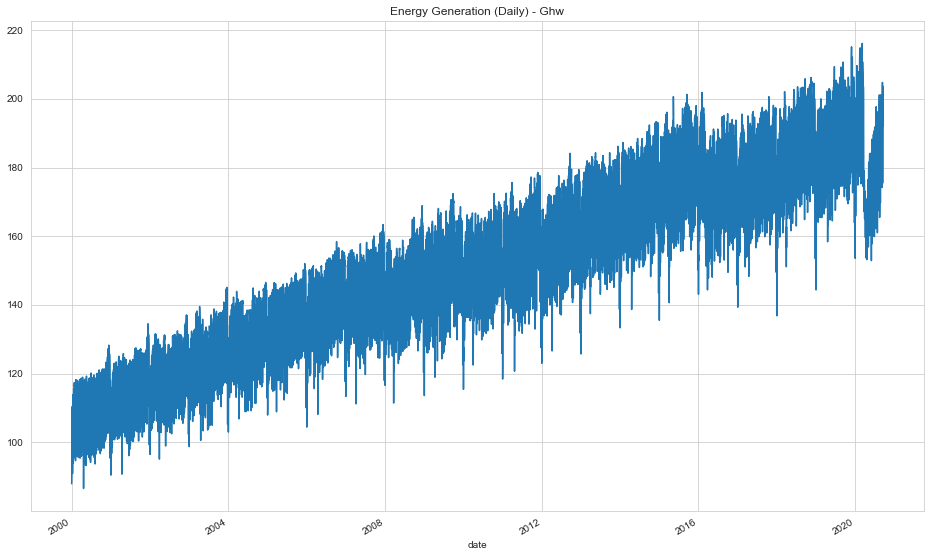

In [31]:
energy_data['generacion_GWh'].plot()
plt.title("Energy Generation (Daily) - Ghw")

# Normality tests

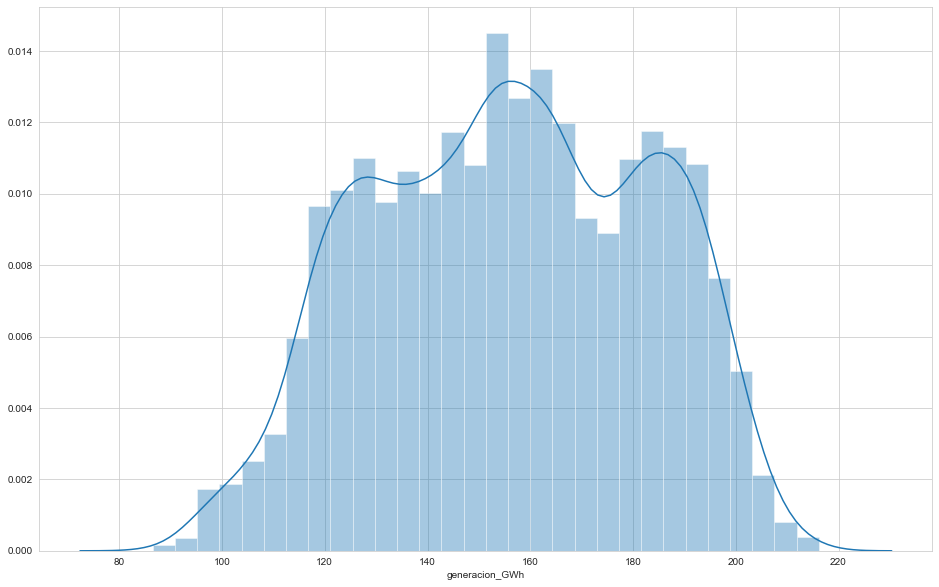

In [32]:
sns.distplot(energy_data['generacion_GWh'])

In [33]:
stat, p = stats.normaltest(energy_data['generacion_GWh'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=1063.999, p=0.000
Data does not look Gaussian (reject H0)


In [34]:
stats.kurtosis(energy_data['generacion_GWh'])

-0.90424902849412

In [35]:
stats.skew(energy_data['generacion_GWh'])

-0.08353614924334736

# Augmented Dickey Fuller test

In [36]:
adfuller(energy_data['generacion_GWh'], autolag='AIC')

(-1.9214796728010077,
 0.3220248347306134,
 36,
 7527,
 {'1%': -3.4312190755290266,
  '5%': -2.86192406579182,
  '10%': -2.5669744337969775},
 47967.07720572307)

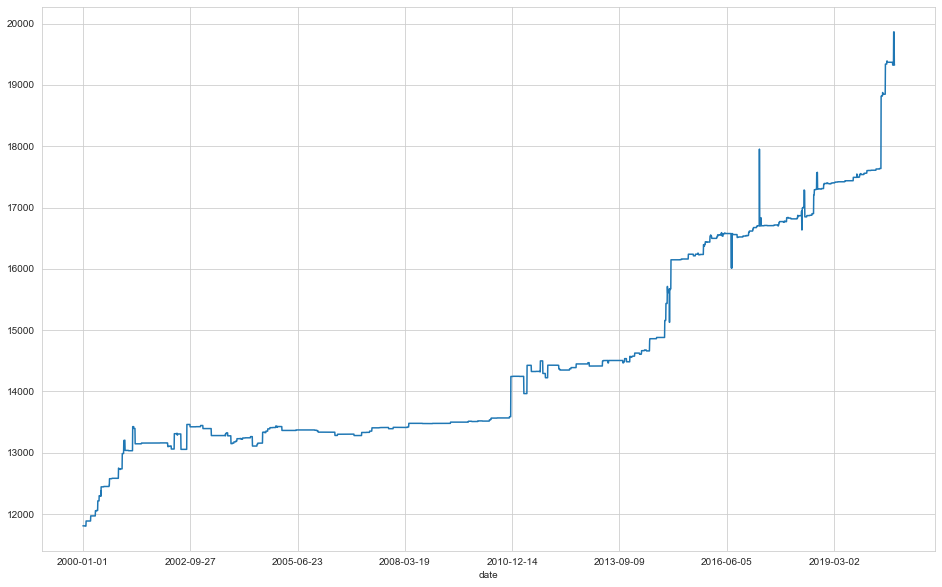

In [21]:
energy_data['capacidad_efectiva_neta_mv'].plot()

# Data Normalization

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Data Split

In [25]:
threshold_date = energy_data.iloc[round(energy_data.shape[0] * 0.8)]
threshold_date.name

Timestamp('2016-07-26 00:00:00')

In [26]:
train_data = energy_data[energy_data.index  <= threshold_date.name]
test_data = energy_data[energy_data.index  > threshold_date.name]

# LSTM Neural Network

Source https://wiki.pathmind.com/lstm

In [9]:
# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

In [76]:
class DeepLearningUTSModel:
    """
    Univariate Time Series Deep Learning Model pipeline Class
    """
    
    def __init__(self, data=None, LSTM_layer_depth=50, epochs=10):
        
        self.data = data
        self.LSTM_layer_depth = LSTM_layer_depth
        self.epochs = epochs
        self.model = None
        self.prophet_ = False
    
    @classmethod
    def create_ts_sequences(cls, series, lag):
        """Create vectors along a time series with
        an specified number of lags"""
        
        X, y = [], []
        
        for t in range(len(series)):
            
            # Index + defined_lag t = [t-1, t-2, ..., t-lag]
            t_plus_lag = t + lag
            
            if t_plus_lag > len(series)-1:
                break
            
            X_seq, y_seq = series[t:t_plus_lag], series[t_plus_lag]
            
            # Append arrays to the 
            X.append(X_seq)
            y.append(y_seq)
            
        # Reshape and transformation to array
        
        X = np.array(X)
        y = np.array(y)
        
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        
        return X, y
        
    def vanillaLSTM(self, X, y, lags, n_features=1):
        """Minimalist LSTM model
            
           n_features=1 for univariate time series
        """
        callback = EarlyStopping(monitor='loss', patience=10)
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(lags, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
                
        model.fit(X, y, epochs=self.epochs, verbose=0, callbacks=[callback])
        
        self.model = model

        return model
    
    def prophet(self, ds, ts):
        """Facebook Prophet estimation
            df: dataframe
            ds: datatime column
            ts: time series
        """
        
        if self.data is None:
            raise TypeError("""
            DataFrame is a None value, initialize 
            the DeepLearningUTSModel with an appropiate dataframe
            """)
            
        columns = ['ds', 'y']
        
        df = self.data[[ds, ts]]
        df.columns = columns
        
        model = Prophet()
        model.fit(df)
        
        self.model = model
        self.prophet_ = True
        future = model.make_future_dataframe(periods=500)
        
        return model, future
    
    def stackedLSTM(self):
        pass

    def bdLSTM(self):
        pass

    def cnnLSTM(self):
        pass

    def convLSTM(self):
        pass

    
    def predict(self, x):
          
        if self.model is not None:
            if self.prophet_ == False:
                predictions = [y[0] for y in self.model.predict(x)]
            else:
                predictions = model.predict(x)
        else:
            raise ValueError("Model haven't fitted.")
        
        return predictions
    

    def predict_future(self, series, lag, n_ahead):
        """Preditions n moments ahead"""
        
        X, _ = DeepLearningUTSModel.create_ts_sequences(series=series, lag=lag)
        
        yhat = []
        for _ in range(n_ahead):
            
            if self.model is not None:
                forecast = self.model.predict(X)
            else:
                raise ValueError("Model haven't fitted.")   
            
            yhat.append(forecast)
                        
            X = np.append(X, forecast)
            # Ommiting the first variable
            X = np.delete(X, 0)
            X = np.reshape(X, (1, len(X), 1))
            
        return yhat
          

# Model training - Energy generation (2000 - 2016)

In [78]:
X_train, y_train = DeepLearningUTSModel.create_ts_sequences(series=train_data['generacion_GWh'], lag=2)
X_test, y_test = DeepLearningUTSModel.create_ts_sequences(series=test_data['generacion_GWh'], lag=2)

lstm_g = DeepLearningUTSModel()
lstm_g.vanillaLSTM(X_train, y_train, lags=2)

# Model prediction (2016 -2020)

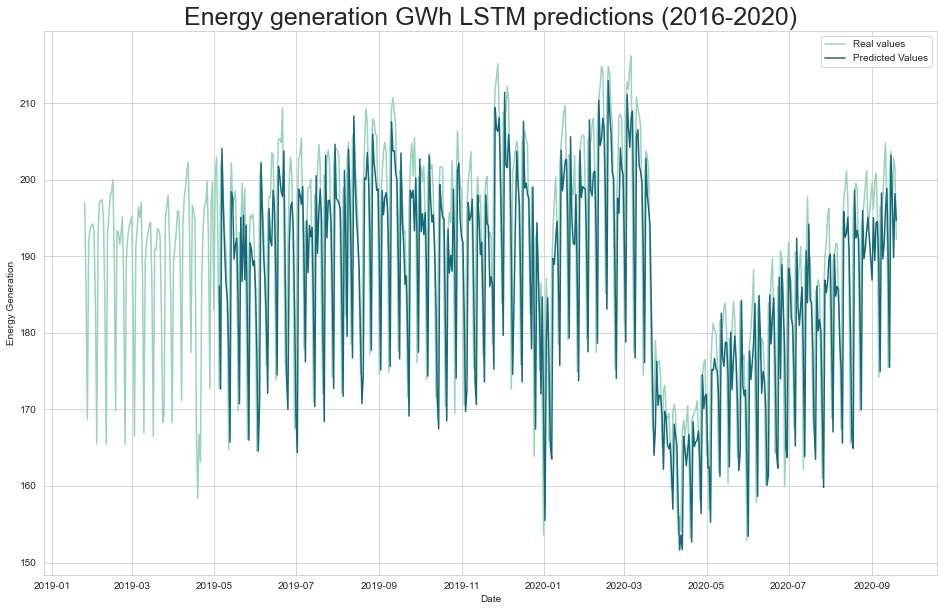

In [71]:
plt.plot(energy_data['generacion_GWh'][-600:], color = '#9ad3bc', label = "Real values")
plt.plot(pd.Series(lstm_g.predict(X_test),index=test_data.index[2:])[-500:], color = '#16697a', label = "Predicted Values")
plt.title("Energy generation GWh LSTM predictions (2016-2020)", fontsize=25)
plt.ylabel("Energy Generation")
plt.xlabel("Date")
plt.legend()

# Model training - Energy capacity (2000 - 2016)

In [24]:
X_train_c, y_train_c = DeepLearningUTSModel.create_ts_sequences(series=train_data['capacidad_efectiva_neta_mv'], lag=5)
X_test_c, y_test_c = DeepLearningUTSModel.create_ts_sequences(series=test_data['capacidad_efectiva_neta_mv'], lag=5)

lstm_c = DeepLearningUTSModel()
lstm_c.vanillaLSTM(X_train_c, y_train_c, lags=5)

NameError: name 'train_data' is not defined

# Model prediction (2016 -2020)

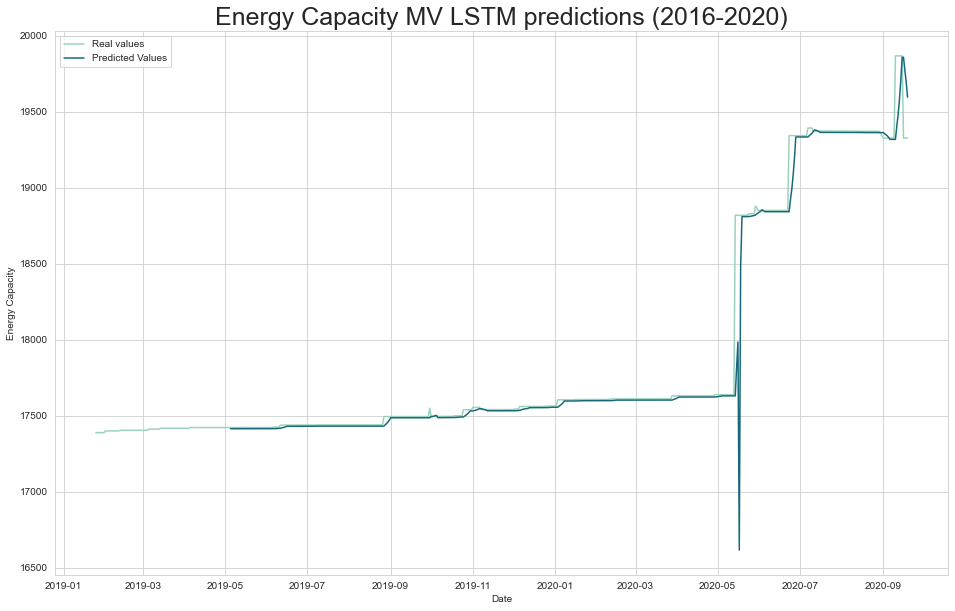

In [126]:
plt.plot(energy_data['capacidad_efectiva_neta_mv'][-600:], color = '#9ad3bc', label = "Real values")
plt.plot(pd.Series(lstm_c.predict(X_test_c),index=test_data.index[5:])[-500:], color = '#16697a', label = "Predicted Values")
plt.title("Energy Capacity MV LSTM predictions (2016-2020)", fontsize=25)
plt.ylabel("Energy Capacity")
plt.xlabel("Date")
plt.legend()

# Facebook Prophet - Energy generation

In [13]:
energy_data[['generacion_GWh']].reset_index()

,date,generacion_GWh
0,2000-01-01,87.924
1,2000-01-02,88.754
2,2000-01-03,105.884
3,2000-01-04,109.207
4,2000-01-05,109.069
...,...,...
7559,2020-09-15,203.681
7560,2020-09-16,196.657
7561,2020-09-17,202.818
7562,2020-09-18,201.580


In [20]:
dl_instance = DeepLearningUTSModel(data=energy_data[['generacion_GWh']].reset_index())
prophet_model, future = dl_instance.prophet(ds='date', ts='generacion_GWh')

NameError: name 'Prophet' is not defined

In [8]:
energy_data

,generacion_GWh,capacidad_efectiva_neta_mv,str_date
date,,,
2000-01-01,87.924,11806.970,2000 enero 01
2000-01-02,88.754,11806.970,2000 enero 02
2000-01-03,105.884,11806.970,2000 enero 03
2000-01-04,109.207,11806.970,2000 enero 04
2000-01-05,109.069,11806.970,2000 enero 05
...,...,...,...
2020-09-15,203.681,19866.117,2020 septiembre 15
2020-09-16,196.657,19326.117,2020 septiembre 16
2020-09-17,202.818,19326.117,2020 septiembre 17


# Model  saving

In [130]:
lstm_g.model.save("../output/LSTM_energy_gen.h5")
lstm_g.model.save("../output/LSTM_energy_cap.h5")